# OCF Open Data PVNet Notebook

The following packages and versions should be installed locally:
```
boto3==1.36.1
botocore==1.36.1
fsspec==2024.12.0
matplotlib==3.9.1
numpy==1.26.4
ocf_data_sampler==0.1.6
pandas==2.2.0
requests==2.32.3
s3fs==0.4.2
seaborn==0.13.2
typing-extensions==4.12.2
xarray==2024.11.0
zarr==2.18.3
```

In [4]:
# Import the following packages
import os
import zipfile
import re
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import pandas as pd
import numpy as np
from ocf_data_sampler.torch_datasets.datasets.pvnet_uk import PVNetUKRegionalDataset
import requests
import pandas as pd
import pkg_resources
import zarr
import fsspec
import s3fs
import matplotlib.pyplot as plt
from typing import Union, Optional, List
import seaborn as sns

In [3]:
# Set your current working directory
cwd = os.getcwd()
cwd

'/media/siddharth899/E/OSS/OpenClimateFix/open-data-pvnet'

In [22]:
import xarray as xr

zarr_path = "s3://ocf-open-data-pvnet/data/gfs/v3/2023.zarr"



In [24]:
ds = xr.open_dataset(
    zarr_path,
    engine="zarr",
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={},  # ← key for lazy loading via Dask
)


In [25]:
# Check actual time values (may need to use .values if it's lazy)
init_times = ds["init_time_utc"].values  # Will not load full data, just coordinate

# Convert to pandas for easy indexing (first 10 just to check)
import pandas as pd
print(pd.to_datetime(init_times[:10]))


DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 06:00:00',
               '2023-01-01 12:00:00', '2023-01-01 18:00:00',
               '2023-01-02 00:00:00', '2023-01-02 06:00:00',
               '2023-01-02 12:00:00', '2023-01-02 18:00:00',
               '2023-01-03 00:00:00', '2023-01-03 06:00:00'],
              dtype='datetime64[ns]', freq=None)


In [26]:
# General overview of the dataset
print(ds.info())

xarray.Dataset {
dimensions:
	init_time_utc = 1415 ;
	step = 17 ;
	latitude = 21 ;
	longitude = 21 ;

variables:
	float32 dlwrf(init_time_utc, step, latitude, longitude) ;
		dlwrf:GRIB_NV = 0 ;
		dlwrf:GRIB_Nx = 360 ;
		dlwrf:GRIB_Ny = 181 ;
		dlwrf:GRIB_cfName = unknown ;
		dlwrf:GRIB_cfVarName = dlwrf ;
		dlwrf:GRIB_dataType = fc ;
		dlwrf:GRIB_gridDefinitionDescription = Latitude/longitude. Also called equidistant cylindrical, or Plate Carree ;
		dlwrf:GRIB_gridType = regular_ll ;
		dlwrf:GRIB_iDirectionIncrementInDegrees = 1.0 ;
		dlwrf:GRIB_iScansNegatively = 0 ;
		dlwrf:GRIB_jDirectionIncrementInDegrees = 1.0 ;
		dlwrf:GRIB_jPointsAreConsecutive = 0 ;
		dlwrf:GRIB_jScansPositively = 0 ;
		dlwrf:GRIB_latitudeOfFirstGridPointInDegrees = 90.0 ;
		dlwrf:GRIB_latitudeOfLastGridPointInDegrees = -90.0 ;
		dlwrf:GRIB_longitudeOfFirstGridPointInDegrees = 0.0 ;
		dlwrf:GRIB_longitudeOfLastGridPointInDegrees = 359.0 ;
		dlwrf:GRIB_missingValue = 3.4028234663852886e+38 ;
		dlwrf:GRIB_name = 

In [48]:
# Keep only January 2023
jan_ds = ds.sel(init_time_utc=slice("2023-01-01", "2023-01-31"))


In [49]:
# Construct forecast time
forecast_times = jan_ds.init_time_utc.values[:, None] + ds.step.values[None, :]

# Flatten to get all unique forecast timestamps
forecast_times_flat = forecast_times.flatten()

# Print range and count
print(f"Time range: {forecast_times_flat.min()} to {forecast_times_flat.max()}")
print(f"Number of timesteps: {forecast_times_flat.size}")

# List variables
print(f"Variables: {list(jan_ds.data_vars)}")


Time range: 2023-01-01T00:00:00.000000000 to 2023-02-02T18:00:00.000000000
Number of timesteps: 2108
Variables: ['dlwrf', 'dswrf', 'hcc', 'lcc', 'mcc', 'prate', 'r', 'sde', 't', 'tcc', 'u10', 'u100', 'v10', 'v100', 'vis']


In [38]:
# Display the dataset's metadata (attributes)
print(jan_ds.attrs)

{'Conventions': 'CF-1.7', 'GRIB_centre': 'kwbc', 'GRIB_centreDescription': 'US National Weather Service - NCEP', 'GRIB_edition': 2, 'GRIB_subCentre': 0, 'description': 'Global Forecast System', 'institution': 'US National Weather Service - NCEP', 'local_grib': '/root/data/gfs/20230101/subset_181c7ed8__gfs.t00z.pgrb2.1p00.f048', 'model': 'gfs', 'product': 'pgrb2.1p00', 'remote_grib': 'https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20230101/00/atmos/gfs.t00z.pgrb2.1p00.f048', 'search': ':[TLMH]CDC:|:[UV]GRD:(?:10|100) m|:RH:sigma|:(?:TMP|VIS|PRATE|SNOD|D[SL]WRF):surface|:RH:100 mb'}


In [39]:
# # Get daily statistics
# daily_mean_temp = jan_ds.air_temperature.mean(dim="datetime")
# daily_max_solar = jan_ds.surface_downwelling_shortwave_flux_in_air.max(dim="datetime")

# # Get specific variables over time
# solar_radiation = jan_ds.surface_downwelling_shortwave_flux_in_air
# cloud_cover = jan_ds.cloud_area_fraction

# Construct a forecast time dimension for easy stats
jan_ds["time"] = (("init_time_utc", "step"), jan_ds.init_time_utc.values[:, None] + ds.step.values[None, :])

# Add a single "time" dimension for reduction operations
jan_ds = jan_ds.stack(datetime=("init_time_utc", "step"))

# Get daily statistics (replace 'time' with 'datetime')
daily_mean_temp = jan_ds["t"].mean(dim="datetime")
daily_max_solar = jan_ds["dswrf"].max(dim="datetime")

# Get specific variables over time
solar_radiation = jan_ds["dswrf"]
cloud_cover = jan_ds["tcc"]


In [40]:
solar_radiation

<xarray.DataArray 'dswrf' (latitude: 21, longitude: 21, datetime: 2108)> Size: 4MB
dask.array<reshape, shape=(21, 21, 2108), dtype=float32, chunksize=(1, 1, 1054), chunktype=numpy.ndarray>
Coordinates:
  * latitude       (latitude) float64 168B 65.0 64.0 63.0 ... 47.0 46.0 45.0
  * longitude      (longitude) float64 168B 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * datetime       (datetime) object 17kB MultiIndex
  * init_time_utc  (datetime) datetime64[ns] 17kB 2023-01-01 ... 2023-01-31T1...
  * step           (datetime) timedelta64[ns] 17kB 00:00:00 ... 2 days 00:00:00
Attributes: (12/33)
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           dswrf
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               W m**-2
    grid_mapping:                             gribfile_projection
    long_name:                                Downward short-wave radiation flux
    standard_name:                            unknown
    units:                                    W m**-2

In [41]:
daily_mean_temp

<xarray.DataArray 't' (latitude: 21, longitude: 21)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(21, 21), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 168B 65.0 64.0 63.0 62.0 ... 47.0 46.0 45.0
  * longitude  (longitude) float64 168B 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/33)
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              air_temperature
    GRIB_cfVarName:                           t
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    grid_mapping:                             gribfile_projection
    long_name:                                Temperature
    standard_name:                            air_temperature
    units:                                    K

In [43]:
# x_coord = -1.156e+05  # meters from projection center
# y_coord = -1.034e+05  # meters from projection center

# # Get time series for this location
# point_radiation = solar_radiation.sel(
#     projection_x_coordinate=x_coord,
#     projection_y_coordinate=y_coord,
#     method='nearest'  # Use nearest neighbor interpolation
# )

# # Create a time series plot
# plt.figure(figsize=(12, 6))
# point_radiation.plot(
#     marker='o',
#     linestyle='-',
#     label='Solar Radiation'
# )

# plt.title(f'Solar Radiation at ({x_coord:.0f}, {y_coord:.0f})')
# plt.xlabel('Time')
# plt.ylabel('Solar Radiation (W/m²)')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Print the values
# print("\nHourly values:")
# for time, value in zip(point_radiation.time.values, point_radiation.values):
#     print(f"{time}: {value}")

In [50]:
import pandas as pd

# Step 1: Recompute forecast_time properly
forecast_time = jan_ds['init_time_utc'].values[:, None] + jan_ds['step'].values[None, :]
forecast_time_flat = forecast_time.flatten()

# Step 2: Cleanly stack to a new dimension (avoid using 'datetime')
jan_ds_unstacked = jan_ds.copy()  # make sure you’re starting clean
stacked_ds = jan_ds_unstacked.stack(forecast_index=("init_time_utc", "step"))

# Step 3: Assign the flat datetime array to a NEW coordinate (e.g., 'forecast_time')
stacked_ds = stacked_ds.assign_coords(forecast_time=("forecast_index", pd.to_datetime(forecast_time_flat)))

# Step 4: Set forecast_time as index (makes plotting and slicing easier)
stacked_ds = stacked_ds.swap_dims({"forecast_index": "forecast_time"})


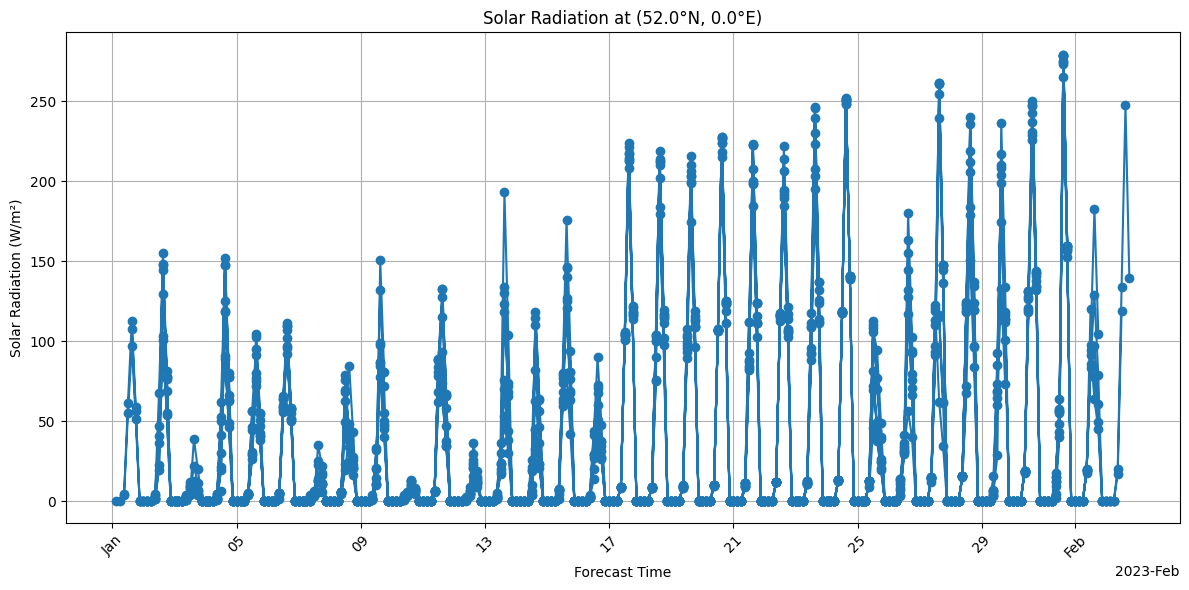

In [52]:
lat = 52.0
lon = 0.0

point_radiation = stacked_ds["dswrf"].sel(
    latitude=lat,
    longitude=lon,
    method="nearest"
)

# Plot
plt.figure(figsize=(12, 6))
point_radiation.plot(marker='o', linestyle='-')
plt.title(f'Solar Radiation at ({lat:.1f}°N, {lon:.1f}°E)')
plt.xlabel('Forecast Time')
plt.ylabel('Solar Radiation (W/m²)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [53]:
print("\nHourly values:")
for time, value in zip(point_radiation.forecast_time.values, point_radiation.values):
    print(f"{pd.to_datetime(time)}: {value:.2f} W/m²")



Hourly values:
2023-01-01 00:00:00: nan W/m²
2023-01-01 03:00:00: 0.00 W/m²
2023-01-01 06:00:00: 0.00 W/m²
2023-01-01 09:00:00: 3.74 W/m²
2023-01-01 12:00:00: 54.78 W/m²
2023-01-01 15:00:00: 96.72 W/m²
2023-01-01 18:00:00: 51.38 W/m²
2023-01-01 21:00:00: 0.00 W/m²
2023-01-02 00:00:00: 0.00 W/m²
2023-01-02 03:00:00: 0.00 W/m²
2023-01-02 06:00:00: 0.00 W/m²
2023-01-02 09:00:00: 1.12 W/m²
2023-01-02 12:00:00: 22.28 W/m²
2023-01-02 15:00:00: 129.72 W/m²
2023-01-02 18:00:00: 68.68 W/m²
2023-01-02 21:00:00: 0.00 W/m²
2023-01-03 00:00:00: 0.00 W/m²
2023-01-01 06:00:00: nan W/m²
2023-01-01 09:00:00: 4.14 W/m²
2023-01-01 12:00:00: 61.44 W/m²
2023-01-01 15:00:00: 112.56 W/m²
2023-01-01 18:00:00: 58.80 W/m²
2023-01-01 21:00:00: 0.00 W/m²
2023-01-02 00:00:00: 0.00 W/m²
2023-01-02 03:00:00: 0.00 W/m²
2023-01-02 06:00:00: 0.00 W/m²
2023-01-02 09:00:00: 1.30 W/m²
2023-01-02 12:00:00: 19.46 W/m²
2023-01-02 15:00:00: 100.40 W/m²
2023-01-02 18:00:00: 54.02 W/m²
2023-01-02 21:00:00: 0.00 W/m²
2023-01-03

In [57]:
# Check latitude and longitude ranges
print("\nLatitude range:")
print(f"Min: {jan_ds.latitude.min().values}")
print(f"Max: {jan_ds.latitude.max().values}")

print("\nLongitude range:")
print(f"Min: {jan_ds.longitude.min().values}")
print(f"Max: {jan_ds.longitude.max().values}")



Latitude range:
Min: 45.0
Max: 65.0

Longitude range:
Min: 0.0
Max: 359.0


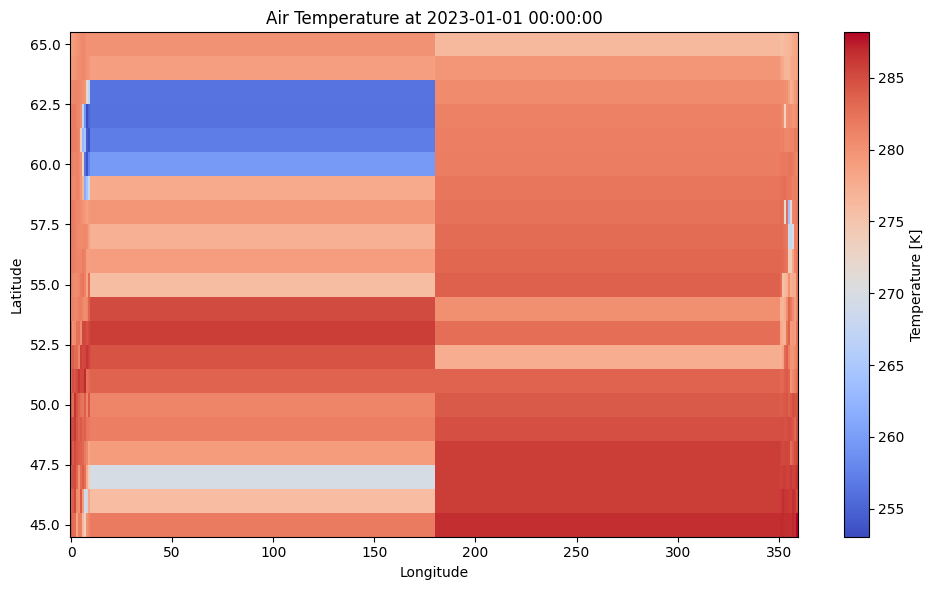

In [58]:
# Select a specific forecast time index
time_index = 0
air_temp = stacked_ds["t"].isel(forecast_time=time_index)

# Plot
plt.figure(figsize=(10, 6))
air_temp.plot(cmap="coolwarm")
plt.title(f"Air Temperature at {pd.to_datetime(stacked_ds.forecast_time.values[time_index])}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


In [59]:
print(jan_ds.coords)

Coordinates:
  * init_time_utc  (init_time_utc) datetime64[ns] 992B 2023-01-01 ... 2023-01...
  * latitude       (latitude) float64 168B 65.0 64.0 63.0 ... 47.0 46.0 45.0
  * longitude      (longitude) float64 168B 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * step           (step) timedelta64[ns] 136B 0 days 00:00:00 ... 2 days 00:...


In [60]:
print(jan_ds.attrs)

{'Conventions': 'CF-1.7', 'GRIB_centre': 'kwbc', 'GRIB_centreDescription': 'US National Weather Service - NCEP', 'GRIB_edition': 2, 'GRIB_subCentre': 0, 'description': 'Global Forecast System', 'institution': 'US National Weather Service - NCEP', 'local_grib': '/root/data/gfs/20230101/subset_181c7ed8__gfs.t00z.pgrb2.1p00.f048', 'model': 'gfs', 'product': 'pgrb2.1p00', 'remote_grib': 'https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20230101/00/atmos/gfs.t00z.pgrb2.1p00.f048', 'search': ':[TLMH]CDC:|:[UV]GRD:(?:10|100) m|:RH:sigma|:(?:TMP|VIS|PRATE|SNOD|D[SL]WRF):surface|:RH:100 mb'}


<hr>

In [61]:
# Get the path to the GSP UK CSV file
csv_path = pkg_resources.resource_filename("ocf_data_sampler", "//data/uk_gsp_locations.csv")

# Try loading the CSV
df_gsp_loc = pd.read_csv(csv_path, index_col="gsp_id")

# Print first few rows
print(df_gsp_loc.head())
print(f"✅ CSV loaded successfully with {df_gsp_loc.shape[0]} rows.")

/tmp/ipykernel_77553/3019048427.py:2: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  csv_path = pkg_resources.resource_filename("ocf_data_sampler", "//data/uk_gsp_locations.csv")


                                                 geometry     x_osgb  \
gsp_id                                                                 
0       MULTIPOLYGON (((83979.99999999894 5180, 83940....  360053.47   
1       MULTIPOLYGON (((246878 54010, 246878 54110, 24...  274767.28   
2       POLYGON ((306749 715731, 306649 715731, 306649...  313426.72   
3       MULTIPOLYGON (((321979.9999999999 165059.99999...  306112.28   
4       MULTIPOLYGON (((513467.45966620307 179705.7363...  516917.84   

            y_osgb  
gsp_id              
0       466142.300  
1        61482.035  
2       714293.200  
3       171875.270  
4       182940.140  
✅ CSV loaded successfully with 318 rows.


<hr>

In [64]:
# s3_path = "s3://ocf-open-data-pvnet/data/uk/pvlive/v0/target_data.nc"

# # Open dataset using fsspec
# fs = fsspec.filesystem("s3", anon=True)  # Anonymous access
# with fs.open(s3_path) as f:
#     ds_gsp = xr.open_dataset(f, engine="h5netcdf")

# print(ds_gsp)


s3_path = "s3://ocf-open-data-pvnet/data/uk/pvlive/v0/target_data.nc"
ds_gsp = xr.open_dataset(s3_path,engine='h5netcdf', backend_kwargs={"storage_options": {"anon": True}})
print(ds_gsp)

<xarray.Dataset> Size: 4MB
Dimensions:        (index: 87699)
Coordinates:
  * index          (index) int64 702kB 0 1 2 3 4 ... 87695 87696 87697 87698
Data variables:
    gsp_id         (index) int64 702kB ...
    datetime_gmt   (index) datetime64[ns] 702kB ...
    generation_mw  (index) float64 702kB ...
    capacity_mwp   (index) float64 702kB ...


In [ ]:
# local_gsp_zarr_file = "pvlive_gsp.zarr"

# # Open dataset using fsspec (anonymous access)
# fs = fsspec.filesystem("s3", anon=True)

# # Open NetCDF file from S3 and load it into memory
# ds_gsp = xr.open_dataset(fs.open(s3_path), engine="h5netcdf").load()

# # Convert to Zarr format
# ds_gsp.to_zarr(local_gsp_zarr_file, mode="w")

# print(f"GSP dataset successfully converted to {local_gsp_zarr_file}")

In [66]:
# print(ds_gsp["gsp_id"])
print(ds_gsp["gsp_id"].values[:100])  # Print first 10 values to inspect

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [67]:
# pv_zarr = "pvlive.zarr.zip"
# year_month = "2024_01"

# store = zarr.storage.ZipStore(pv_zarr, mode="r")
# group_path = f"zarr/target_data_{year_month}.zarr" 

# ds_pv = xr.open_zarr(store, group=group_path, consolidated=False)

# df_pv = ds_pv.to_dataframe()

# print(ds_pv)
# print(df_pv.head())

In [68]:
# pvlive_path = os.path.join(cwd, pv_zarr)
# pvlive_path

<hr>

In [ ]:
# # Read the template YAML file
# with open("config_template.yaml", "r") as file:
#     yaml_content = file.read()

In [ ]:
# PROVIDER = "gfs"
# ZARR_ZIPE = "2023.01.zarr.zip"

In [ ]:
# # Replace the PVlive placeholder with the actual path
# yaml_content = yaml_content.replace("{zarr_gsp_path}", pvlive_path)
# yaml_content = yaml_content.replace(PROVIDER, gfs)

# # Replace the placeholder with the actual path of nwp data
# yaml_content = yaml_content.replace("{zarr_path}", zarr_zip_file_month)

# # Save the modified YAML as config.yaml
# config_file_path = os.path.join(cwd, "config.yaml")

# with open(config_file_path, "w") as file:
#     file.write(yaml_content)

# print(f"Updated YAML file saved to: {config_file_path}")

Updated YAML file saved to: /Users/jacquescamier/Development/ML_AI/nwp_data_researcher/config.yaml


In [70]:
# Load dataset using your configuration file
dataset = PVNetUKRegionalDataset(config_filename="PVNet/configs/datamodule/configuration/example_configuration.yaml", gsp_ids=[0])

# Print dataset info
print(f"Dataset length: {len(dataset)}")
print(f"Sample keys: {dataset[0].keys()}")

Converting longitude from 0-360 to -180-180
Dataset length: 17041
Sample keys: dict_keys(['nwp', 'gsp', 'gsp_nominal_capacity_mwp', 'gsp_effective_capacity_mwp', 'gsp_time_utc', 'gsp_t0_idx', 'gsp_id', 'gsp_x_osgb', 'gsp_y_osgb'])
